# Анализ данных сервиса аренды самокатов GoFast

В ходе проекта нам предстоит проанализировать данные сервиса аренды самокатов GoFast и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.\
Начнем с изучения данных:

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В первом датафрейме содержится основная информация о пользователях приложения: уникальный идентификатор пользователя, имя, возраст, город и тип подписки. Всего в таблице 1565 пользователей. 

In [3]:
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
print(rides.info())
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Во втором датафрейме представлена информация о поездках: уникальный идентификатор пользователя, расстояние в метрах, время в минутах и дата поездки. В данной таблице стоит изменить тип данных даты со строки на дату pandas.

In [4]:
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
print(subscriptions.info())
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В последнем датафрейме содержится информация о типах подписки. Их всего 2: free и ultra, также описаны отличительные черты каждого типа подписки: стоимость одной минуты поездки, стоимость начала поездки и стоимость ежемесячного платежа.

#### Шаг 2. Предобработка данных

2.1. Приведем столбец date из таблицы rides к типу даты pandas. 

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


2.2. Создадим новый столбец с номером месяца на основе столбца date в таблице rides.

In [6]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


2.3. Проверим наличие пропущенных значений и дубликатов в датафреймах. 

In [7]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропущенные значения отсутствуют, проверим явные дубликаты и неявные в столбце city:

In [8]:
#посчитаем количесвто дубликатов 
users.duplicated().sum()

31

In [9]:
#удалим явные дубликаты
users = users.drop_duplicates()

In [10]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Неявных дубликатов в столбце с городами тоже нет. Перейдем у изучению таблицы с поездками. 

In [11]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропуски отсутствуют, посмотрим дубликаты:

In [12]:
rides.duplicated().sum()

0

Все в порядке. Исследовать последнюю таблицу не нужно, так как там всего 2 строки и 4 столбца, там нет ни пропусков, ни дубликатов.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

3.1 частота встречаемости городов

In [13]:
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

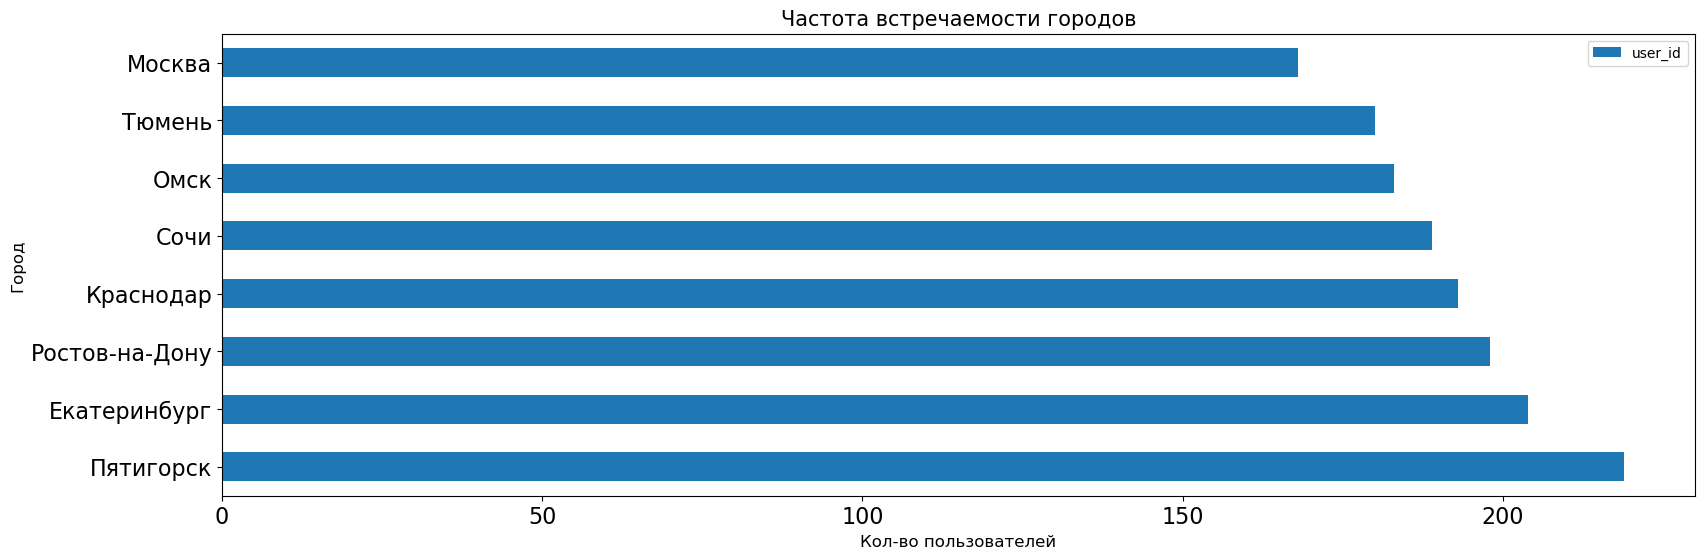

In [36]:
city_us = users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values('user_id', ascending=False)\
.plot(kind = 'barh', y='user_id', figsize = (19,6), fontsize = 16)
plt.title('Частота встречаемости городов', fontsize=15)
plt.xlabel('Кол-во пользователей', fontsize=12)
plt.ylabel('Город', fontsize=12)
plt.show()

Как ни странно, реже всего встречается Москва, возможно, потому что там популярны другие сервисы аренды самокатов. Больше всего пользователей из Пятигорска, Екатеринбурга и Ростова-на-Дону. В целом, можно сказать, что разброс не очень большой, значения частоты встречаемости городов лежат в промежутке от 168 до 219.

3.2 соотношение пользователей с подпиской и без подписки

In [15]:
print(users['subscription_type'].value_counts())
print()
percent = users.groupby('subscription_type')['user_id'].count() / users['user_id'].count()
print('Доли категорий пользователей', percent)

subscription_type
free     835
ultra    699
Name: count, dtype: int64

Доли категорий пользователей subscription_type
free     0.544329
ultra    0.455671
Name: user_id, dtype: float64


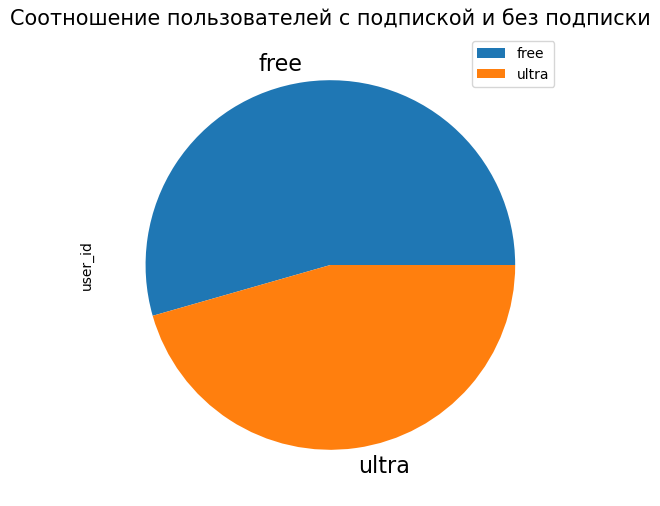

In [35]:
#users['subscription_type'].hist(figsize=(10,5), bins=4)
sub = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').plot(
    kind='pie', y='user_id', figsize = (12,6), fontsize = 16)
plt.title('Cоотношение пользователей с подпиской и без подписки', fontsize=15)
plt.show()

Больше пользователей используют сервис аренды самокатов без подписки-их 835, что почти на 20% больше, чем пользователей с подпиской ultra.

3.3 возраст пользователей

In [17]:
users['age'].value_counts()

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64

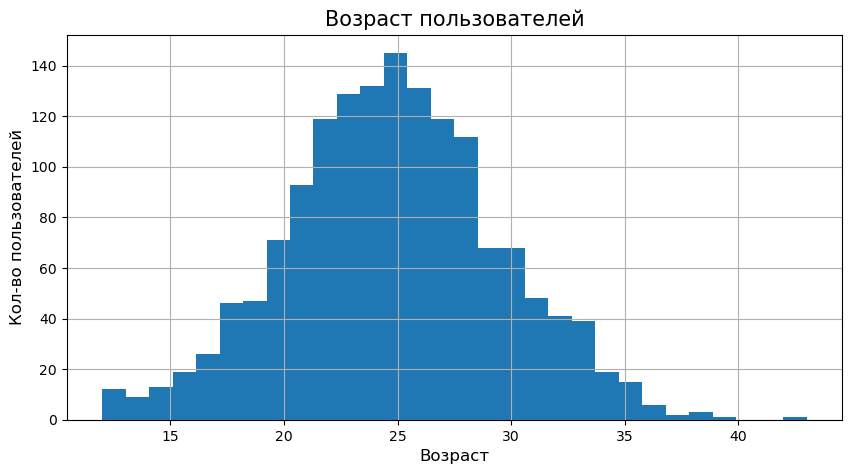

In [37]:
users['age'].hist(figsize=(10,5), bins=30)
plt.title('Возраст пользователей', fontsize=15)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

В основном сервисом пользуется молодежь, пользователи от 20 до 30 лет. Менее востребована аренда самокатов для несовершеннолетних лиц и для людей старше 30 лет.

3.4 расстояние, которое пользователь преодолел за одну поездку

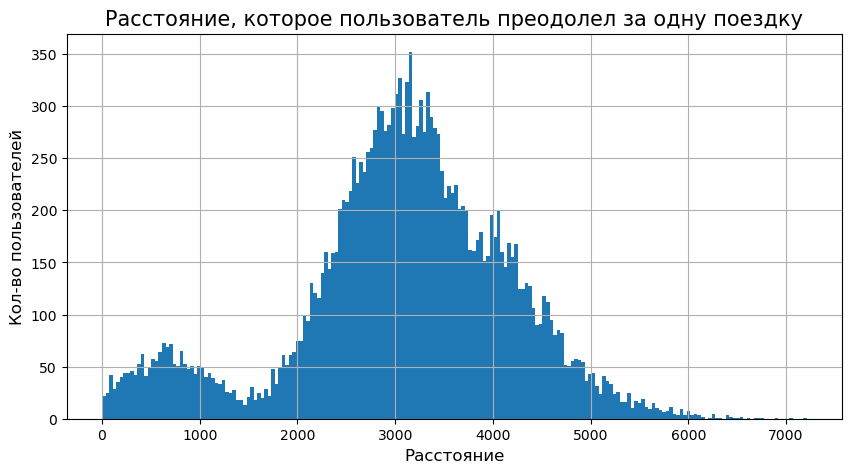

In [38]:
rides['distance'].hist(figsize=(10,5), bins=200)
plt.title('Расстояние, которое пользователь преодолел за одну поездку', fontsize=15)
plt.xlabel('Расстояние', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

Пользователи совершают как короткие поездки на небольшие дистанции, так и длинные. Чаще всего всречаются поездки от 2 до 5 км.

3.5 продолжительность поездок

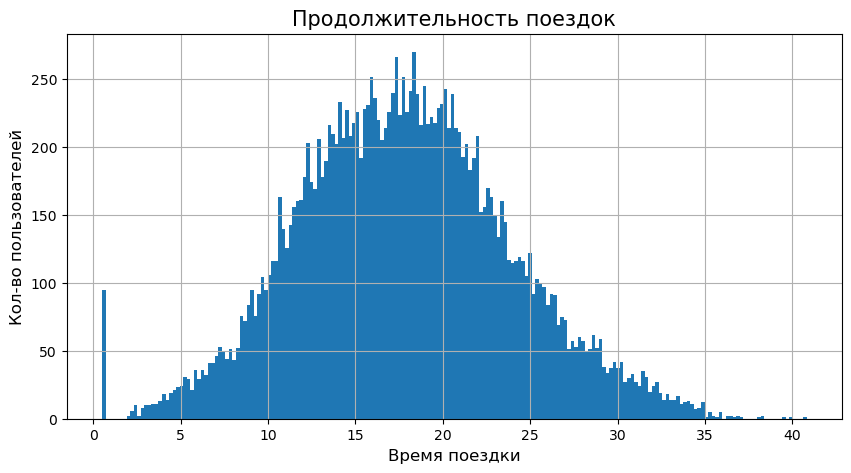

In [39]:
rides['duration'].hist(figsize=(10,5), bins=200)
plt.title('Продолжительность поездок', fontsize=15)
plt.xlabel('Время поездки', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

В среднем на поездку пользователи тратят от 5 до 35 минут. Чаще всего продолжительность поездки находится в промежутке от 15 до 20 минут.

#### Шаг 4. Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [21]:
data = users.merge(rides, on='user_id', how='left')
data = data.merge(subscriptions, on='subscription_type', how='left')
data['duration'] = np.ceil(data['duration']) 
print('Кол-во строк новой таблицы:' ,data.shape[0])
print()
print('Кол-во пропусков:', data.isna().sum())
data.head()

Кол-во строк новой таблицы: 18068

Кол-во пропусков: user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


Теперь все данные находятся в одной таблице. Кол-во строк нового датаврейма совпадает с кол-вом строк таблицы с поездками. Пропусков в новой таблице нет. 

4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1: c данными о пользователях без подписки (data_free);
с данными о пользователях с подпиской (data_ultra).

In [22]:
data_free = data.query('subscription_type == "free"')
data_free.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,23.0,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,19.0,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,16.0,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,17.0,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,12.0,2021-06-23,6,8,50,0


In [23]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,17.0,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,15.0,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,24.0,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,16.0,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,16.0,2021-11-22,11,6,0,199


4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

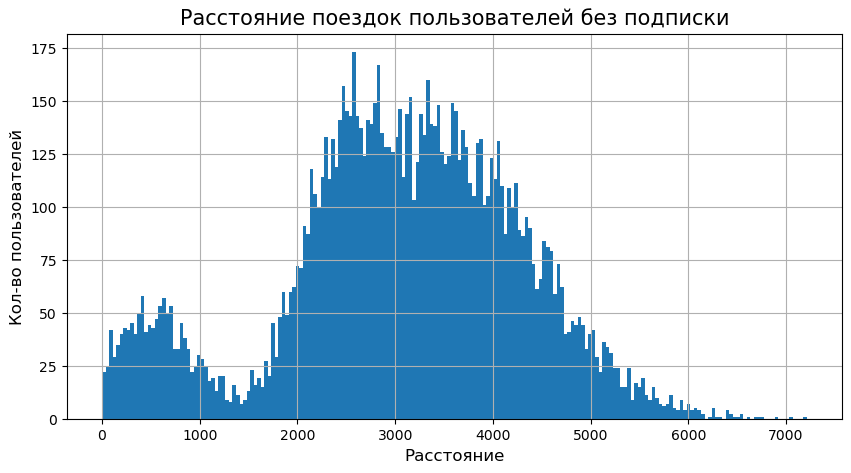

In [40]:
data_free['distance'].hist(figsize=(10,5), bins=200)
plt.title('Расстояние поездок пользователей без подписки', fontsize=15)
plt.xlabel('Расстояние', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

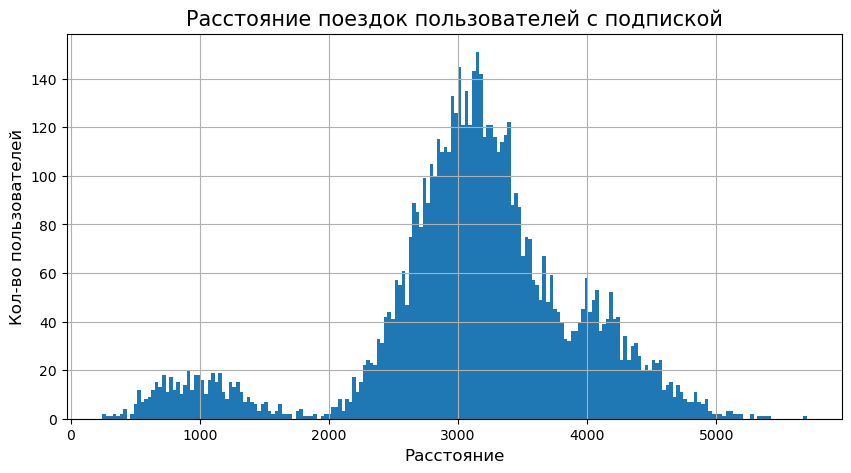

In [41]:
data_ultra['distance'].hist(figsize=(10,5), bins=200)
plt.title('Расстояние поездок пользователей c подпиской', fontsize=15)
plt.xlabel('Расстояние', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

Расстояния поездки у пользователей без подписки самые разнообразные. Чаще оно составляет от 2 до 4,5 км. У пользователей с подпиской самая распространенная дистанция около 3 км. 

Посмотрим на время в пути.

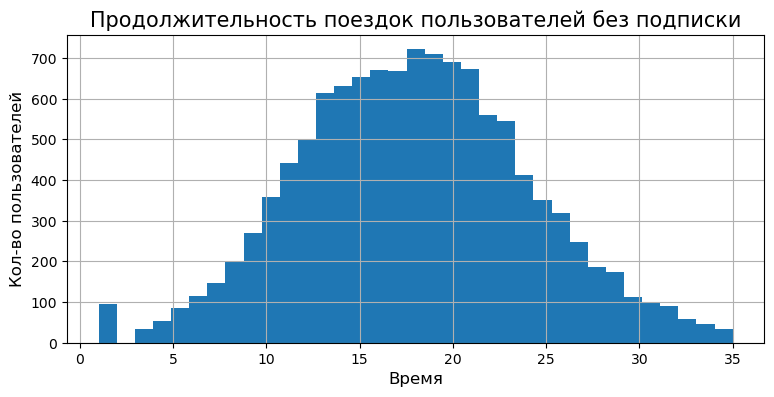

In [42]:
data_free['duration'].hist(figsize=(9,4), bins=35)
plt.title('Продолжительность поездок пользователей без подписки', fontsize=15)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

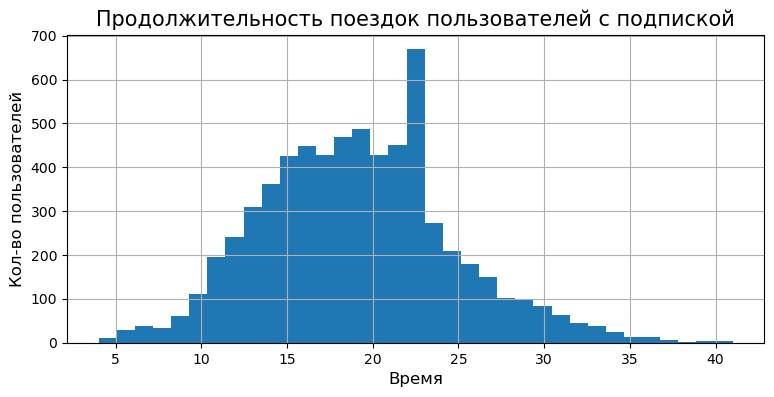

In [43]:
data_ultra['duration'].hist(figsize=(9,4), bins=35)
plt.title('Продолжительность поездок пользователей с подпиской', fontsize=15)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.show()

Графики времени в пути похожи, но несколько отличий все же есть. Во-первых, пользователи с подпиской реже тратят меньше 5 минут, это может быть связано со случайными ошибками новичков в аренде самокатов или с тем, что люди без подписки просто хотят опробовать новое средство передвижения. Во-вторых, пользователи без подписки не трятят больше 35 минут, а у людей с подпиской ultra такие случаи есть. Средние значения у обеих категорий похожи, это примерно 15-20 минут в пути.

#### Шаг 5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [28]:
data_new = pd.pivot_table(data, index=['user_id', 'month'],
                          values=['distance', 'duration', 'subscription_type', 'minute_price', 'start_ride_price','subscription_fee'],
                          aggfunc={'distance':'sum', 'duration':['sum','count'], 'subscription_type': 'first',
                                  'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'}
                         ).reset_index()
data_new.columns = ['id','месяц', 'суммарное расстояние', 'кол-во поездок', 'суммарное время','цена минуты','цена старта','цена подписки','тип_подписки']
print('Кол-во пропусков:', data_new.isna().sum())
data_new

Кол-во пропусков: id                      0
месяц                   0
суммарное расстояние    0
кол-во поездок          0
суммарное время         0
цена минуты             0
цена старта             0
цена подписки           0
тип_подписки            0
dtype: int64


,id,месяц,суммарное расстояние,кол-во поездок,суммарное время,цена минуты,цена старта,цена подписки,тип_подписки
0,1,1,7027.511294,2,42.0,6,0,199,ultra
1,1,4,754.159807,1,7.0,6,0,199,ultra
2,1,8,6723.470560,2,46.0,6,0,199,ultra
3,1,10,5809.911100,2,32.0,6,0,199,ultra
4,1,11,7003.499363,3,56.0,6,0,199,ultra
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,8,50,0,free
11327,1534,8,7622.453034,2,48.0,8,50,0,free
11328,1534,9,4928.173852,1,23.0,8,50,0,free
11329,1534,11,13350.015305,4,78.0,8,50,0,free


Пропусков в таблице нет.

5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [29]:
data_new['выручка'] = (data_new['цена старта'] * data_new['кол-во поездок'] +
                       (data_new['цена минуты'] * data_new['суммарное время']) + data_new['цена подписки'])
data_new.head(10)

,id,месяц,суммарное расстояние,кол-во поездок,суммарное время,цена минуты,цена старта,цена подписки,тип_подписки,выручка
0,1,1,7027.511294,2,42.0,6,0,199,ultra,451.0
1,1,4,754.159807,1,7.0,6,0,199,ultra,241.0
2,1,8,6723.470560,2,46.0,6,0,199,ultra,475.0
3,1,10,5809.911100,2,32.0,6,0,199,ultra,391.0
4,1,11,7003.499363,3,56.0,6,0,199,ultra,535.0
5,1,12,6751.629942,2,28.0,6,0,199,ultra,367.0
6,2,3,10187.723006,3,63.0,6,0,199,ultra,577.0
7,2,4,6164.381824,2,40.0,6,0,199,ultra,439.0
8,2,6,3255.338202,1,14.0,6,0,199,ultra,283.0
9,2,7,6780.722964,2,48.0,6,0,199,ultra,487.0


#### Шаг 6. Проверка гипотез

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза: средние значения трат времени на поездки пользователей из двух групп равны.\
Альтернативная гипотеза: среднее значение трат времени на поездки пользователей с подпиской больше, чем среднее значение трат пользователей без подписки.

Будем проверять одностороннюю гипотезу для средних двух генеральных совокупностей.

In [30]:
ultra_duration = data_ultra['duration']
free_duration = data_free['duration']
alpha = 0.05
results1 = st.ttest_ind(ultra_duration, free_duration, alternative='greater')

print('p-value:', results1.pvalue)

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки в сервисе.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза: среднее расстояние одной поездки пользователей с подпиской равно 3130 метров.\
Альтернативная гипотеза: среднее расстояние одной поездки пользователей с подпиской превышает оптимальное, равное 3130 метров.

Будем проверять правостороннюю гипотезу.

In [31]:
ultra_distance = data_ultra['distance']
normal_distance = 3130
alpha = 0.05

results2 = st.ttest_1samp(ultra_distance, normal_distance, alternative='greater')

print('p-value:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Полученное значение p-value больше заданного уровня значимости, поэтому у нас нет оснований отвергнуть нулевую гипотезу. Можно сказать, что расстояние, которое проезжают пользователи с подпиской не превышает оптимальное с точки зрения износа самоката.


6.3. Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Нулевая гипотеза: средние значения принесенной помесячной выручки пользователей из двух групп равны.\
Альтернативная гипотеза: средние значения принесенной помесячной выручки пользователей с подпиской больше, чем средние значения пользователей без подписки.

Будем проверять одностороннюю гипотезу для средних двух генеральных совокупностей (правостороннюю).

In [32]:
ultra = data_new.query('тип_подписки == "ultra"')
ultra_gain = ultra['выручка']
free = data_new.query('тип_подписки == "free"')
free_gain = free['выручка']

alpha = 0.05

results3 = st.ttest_ind(ultra_gain, free_gain, alternative='greater')

print('p-value:', results3.pvalue)

if results3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки данной гипотезы понадобился бы t-test, а конкретно метод scipy.stats.ttest_rel(), так как эти выборки зависимые. На входе имеем 2 выборки одинакового размера до и после обновления сервера, а на выходите, аналогично предыдущим методам,- p-value для результата. Далее сравнили бы это значение с уровнем значимости и сделали бы выбор в пользу гипотезы H1 или Н0. Так как нам необходимо выяснить снизилось ли количество обращений после обновления, мы будем проверять одностороннюю, а именно левостороннюю гипотезу.

#### Общий вывод

В ходе исследования были изучены данные сервиса по аренде самокатов. \
Сначала была проведена предобработка данных:
1) тип столбца date в таблице rides был изменен на тип даты\
2) был добавлен новый столбец с месяцем поездки\
3) были удалены дубликаты

Далее были изучены и визуализированы данные по:
- частоте встречаемости городов;
- соотношению пользователей с подпиской и без подписки;
- возрасту пользователей;
- расстоянию, которое пользователь преодолел за одну поездку;
- продолжительности поездок.

Была создана общая таблица с данными и 2 отдельных, с данными о поездках пользователей с подпиской и без. По ним была визуализирована информация о расстоянии и и времени поездок для пользователей обеих категорий.\
Была найдена помесячная выручка, которую принёс каждый пользователь.\
Также были проверены три гипотезы и были сделаны следующие выводы:
1. Пользователи с подпиской тратят больше времени на поездки в сервисе
2. Расстояние, которое проезжают пользователи с подпиской не превышает оптимальное с точки зрения износа самоката
3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Подводя итог, можем сказать, что пользователи с подпиской действительно являются более выгодными для компании, так как они тратят больше времени на поездки и приносят больше выручки каждый месяц по сравнению с пользователями, не использующими подписку. Компании следует расширять долю пользователей с подпиской, привлекая различные рекламные кампании и акции, это поможет сервису нарастить свою прибыль и привлечь новых пользователей. 